In [1]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

c:\users\slwal\anaconda3\envs\py36\avgn_paper-2\avgn\utils\general.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [3]:
DATASET_ID = "git_repos"

In [4]:
DT_ID = '2022-03-04_18-41-29'

### Create Dataset

In [5]:
# create a set of hyperparameters for processing this dataset.  
hparams = HParams(
    num_mel_bins = 64,
    mel_lower_edge_hertz=400,
    mel_upper_edge_hertz=8000,
    butter_lowcut = 400,
    butter_highcut = 8000,
    ref_level_db = 20,
    min_level_db = -25,
    mask_spec = False,
    win_length_ms = 5,
    hop_length_ms = 1,
    nex=-1,
    n_jobs=-1,
    verbosity = 1,
)


In [6]:
# create a dataset object, which
dataset = DataSet(DATASET_ID, hparams = hparams)

loading json:   0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    3.9s finished


getting unique individuals:   0%|          | 0/152 [00:00<?, ?it/s]

In [7]:
import json

In [8]:
# to make sure everything loaded correctly, lets look at a sample JSON
dataset.sample_json

OrderedDict([('filename', 'BWY MGGY Call Combo 1 290719 PM'),
             ('samplerate_hz', 44100),
             ('sex', 'F'),
             ('group', 'BWYa'),
             ('location', 'CRAWLEY'),
             ('wav_loc',
              'C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-2/data/raw/magpie/individuals/BWYa_F_MGGY/BWY MGGY Call Combo 1 290719 PM.WAV'),
             ('length_s', 2.1197732426303855),
             ('species', 'Gymnorhina tibicen dorsalis'),
             ('common_name', 'Western Australian magpie'),
             ('indvs',
              OrderedDict([('MGGY',
                            OrderedDict([('call',
                                          OrderedDict([('labels',
                                                        ['DSSHDS',
                                                         'DSSHDS',
                                                         'DSSHDS',
                                                         'SHSHLH',
                             

In [9]:
# how many wavs are in the dataset?
len(dataset.data_files)

152

In [10]:
import librosa

### Create a a pandas dataframe from the dataset
- We use joblib to parallelize the code, but all we're doing is grabbing the segment start and stop times from the JSONs

In [11]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [12]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    seg_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[
                'labels', 'ID', 'start_times', 'end_times', 'call_label', 'call_start', 'seg_pos_call', 'call_unique_num', 'call_pos_combi', 'combi_label', 'combi_start', 'seg_pos_combi', 'combi_unique_num'
            ],
            unit="seg",
            dict_features_to_retain = ['filename', 'group', 'location','sex', 'wav_loc'],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
seg_df = pd.concat(seg_dfs)
len(seg_df)

  0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1965s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0891s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 145 out of 152 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:   

1644

In [13]:
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,seg_pos_combi,combi_unique_num,indv,indvi,filename,group,location,sex,wav_loc,key
0,0.753604,0.776773,DS,0.0,0.753604,0.776773,DSSHDS,0.753604,0.0,0.0,...,0.0,0.0,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM
1,0.786865,0.835165,SH,1.0,0.786865,0.835165,DSSHDS,0.753604,1.0,0.0,...,1.0,0.0,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM
2,0.855941,0.921160,DS,2.0,0.855941,0.921160,DSSHDS,0.753604,2.0,0.0,...,2.0,0.0,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM


In [14]:
##convert to integers
seg_df["call_unique_num"] = seg_df["call_unique_num"].astype(int)
seg_df["seg_pos_call"] = seg_df["seg_pos_call"].astype(int)
seg_df["seg_pos_combi"] = seg_df["seg_pos_combi"].astype(int)
seg_df["combi_unique_num"] = seg_df["combi_unique_num"].astype(int)
seg_df["call_pos_combi"] = seg_df["call_pos_combi"].astype(int)
seg_df["ID"] = seg_df["ID"].astype(int)

In [15]:
len(seg_df)

1644

In [16]:
seg_df[1649:1651]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,seg_pos_combi,combi_unique_num,indv,indvi,filename,group,location,sex,wav_loc,key


In [17]:
seg_df.sort_values(by=['ID'])

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,seg_pos_combi,combi_unique_num,indv,indvi,filename,group,location,sex,wav_loc,key
0,0.753604,0.776773,DS,0,0.753604,0.776773,DSSHDS,0.753604,0,0,...,0,0,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,1,0,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM
2,0.855941,0.921160,DS,2,0.855941,0.921160,DSSHDS,0.753604,2,0,...,2,0,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM
3,0.932017,0.942875,SH,3,0.932017,0.942875,SHSHLH,0.932017,0,1,...,3,0,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM
4,0.951561,0.980101,SH,4,0.951561,0.980101,SHSHLH,0.932017,1,1,...,4,0,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,1.378323,1.415477,DS,1642,1.378323,1.415477,LHDS,1.218702,1,696,...,3,272,MXXGRY,0,SS MXXGRY XXXX JUVENILE Call Combination Serie...,SS,GUILDFORD,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,SS MXXGRY XXXX JUVENILE Call Combination Serie...
0,0.112036,0.138211,SH,1643,0.112036,0.138211,SHDS,0.112036,0,697,...,0,273,MXXGRY,0,SS MXXGRY XXXX JUVENILE Call Combination Serie...,SS,GUILDFORD,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,SS MXXGRY XXXX JUVENILE Call Combination Serie...
1,0.158824,0.238986,DS,1644,0.158824,0.238986,SHDS,0.112036,1,697,...,1,273,MXXGRY,0,SS MXXGRY XXXX JUVENILE Call Combination Serie...,SS,GUILDFORD,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,SS MXXGRY XXXX JUVENILE Call Combination Serie...
2,0.295263,0.474563,LH,1645,0.295263,0.474563,LHDS,0.295263,0,698,...,2,273,MXXGRY,0,SS MXXGRY XXXX JUVENILE Call Combination Serie...,SS,GUILDFORD,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,SS MXXGRY XXXX JUVENILE Call Combination Serie...


### For each segment, grab the corresponding audio
- Here we're looking through the wav files corresponding to the syllable, and grabbing the audio starting at `start_time` and ending at `end_time`

In [18]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    seg_dfs = parallel(
        delayed(get_row_audio)(
            seg_df[seg_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(seg_df.key.unique())
    )
seg_df = pd.concat(seg_dfs)
len(seg_df)

  0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0282s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0952s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1563s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 129 out of 152 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 152 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    0.6s finished


1644

In [19]:
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,indv,indvi,filename,group,location,sex,wav_loc,key,audio,rate
0,0.753604,0.776773,DS,0,0.753604,0.776773,DSSHDS,0.753604,0,0,...,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,"[0.00046081832, 0.0005334763, 0.0005827676, 0....",44100
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,"[-0.00029154422, 0.0038232768, 0.0055759, 0.00...",44100
2,0.855941,0.921160,DS,2,0.855941,0.921160,DSSHDS,0.753604,2,0,...,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,"[0.020170124, -0.007718325, -0.03898641, -0.06...",44100


In [20]:
segs = seg_df.audio.values

  0%|          | 0/50 [00:00<?, ?it/s]

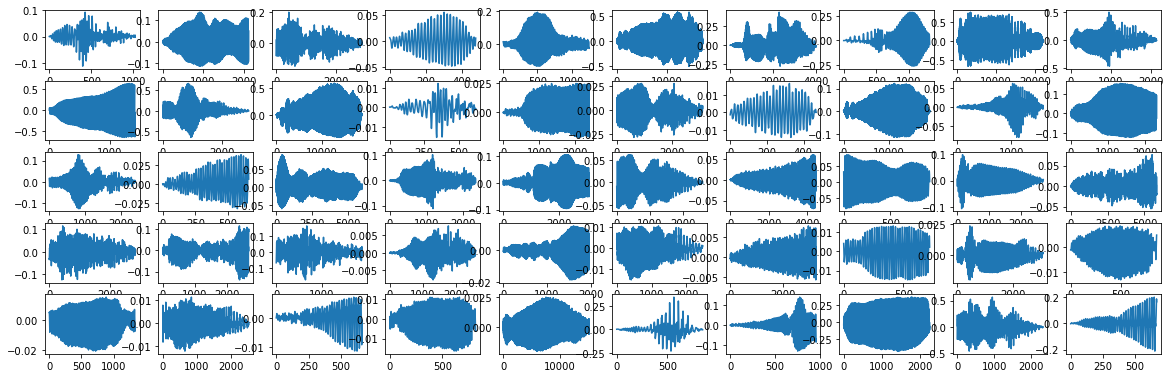

In [21]:
#plot some example audio
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, seg in tqdm(enumerate(segs), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(seg)
    if i == nrows*ncols -1:
        break

In [22]:
audio_lens = np.array([len(i) for i in seg_df['audio']])

(array([100., 272., 132., 166., 186., 195., 141.,  66.,  26.,  17.,  12.,
         10.,  22.,  25.,  25.,  12.,  11.,   9.,  12.,   5.,   7.,  12.,
         13.,   6.,   9.,  10.,  11.,  14.,  14.,  18.,  18.,   4.,  12.,
          8.,   6.,   7.,   7.,   4.,   2.,   2.,   2.,   5.,   3.,   1.,
          2.,   2.,   0.,   0.,   0.,   1.]),
 array([  292. ,   815.2,  1338.4,  1861.6,  2384.8,  2908. ,  3431.2,
         3954.4,  4477.6,  5000.8,  5524. ,  6047.2,  6570.4,  7093.6,
         7616.8,  8140. ,  8663.2,  9186.4,  9709.6, 10232.8, 10756. ,
        11279.2, 11802.4, 12325.6, 12848.8, 13372. , 13895.2, 14418.4,
        14941.6, 15464.8, 15988. , 16511.2, 17034.4, 17557.6, 18080.8,
        18604. , 19127.2, 19650.4, 20173.6, 20696.8, 21220. , 21743.2,
        22266.4, 22789.6, 23312.8, 23836. , 24359.2, 24882.4, 25405.6,
        25928.8, 26452. ]),
 <BarContainer object of 50 artists>)

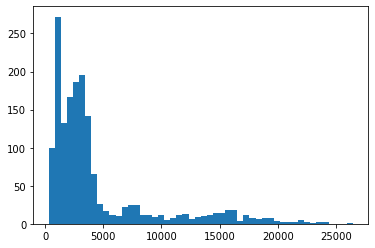

In [23]:
plt.hist(audio_lens, bins=50)

In [24]:
# this is just getting rid of syllables that are zero seconds long, which be the product of errors in segmentation
df_mask  = np.array([len(i) > 0 for i in tqdm(seg_df.audio.values)])
seg_df = seg_df[np.array(df_mask)]

  0%|          | 0/1644 [00:00<?, ?it/s]

### Normalize the audio
- you can skip this step if you don't want to normalize the audio

In [25]:
import librosa

In [26]:
seg_df['audio'] = [librosa.util.normalize(i) for i in seg_df.audio.values]

In [27]:
import matplotlib.pyplot as plt

  0%|          | 0/50 [00:00<?, ?it/s]

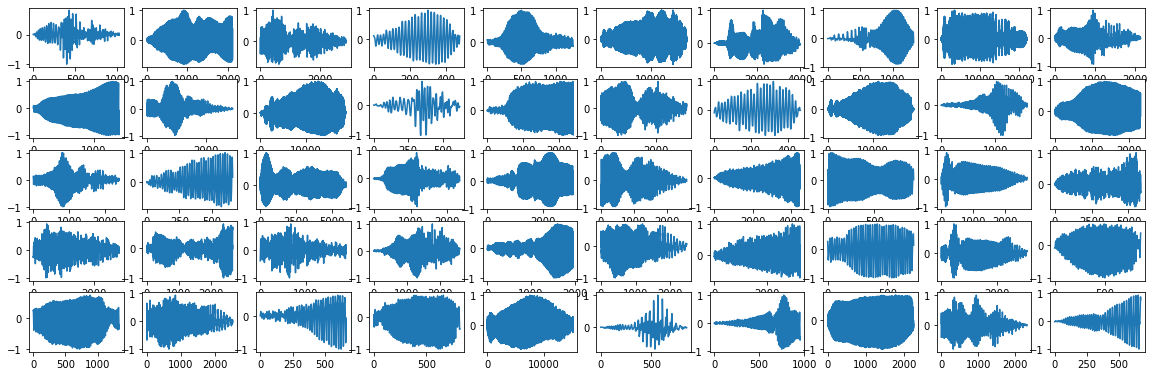

In [28]:
# plot some example audio 
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, seg in tqdm(enumerate(seg_df['audio'].values), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(seg)
    if i == nrows*ncols -1:
        break

## Create Spectrograms

In [29]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [30]:
segs_wav = seg_df.audio.values
segs_rate = seg_df.rate.values

In [31]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    segs_spec = parallel(
        delayed(make_spec)(
            seg,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for seg, rate in tqdm(
            zip(segs_wav, segs_rate),
            total=len(seg_df),
            desc="getting segment spectrograms",
            leave=False,
        )
    )

getting syllable spectrograms:   0%|          | 0/1644 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0133s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0430s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0409s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0606s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch com

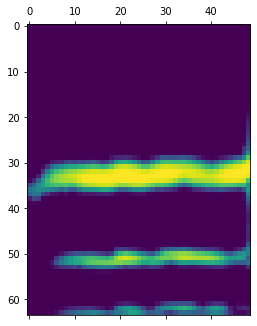

In [32]:
# plot an example segment
plt.matshow(segs_spec[1])

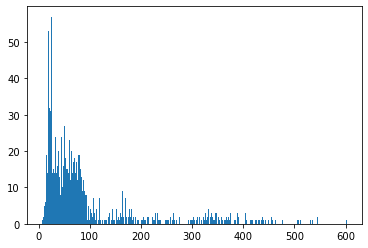

In [33]:
seg_lens = [np.shape(i)[1] for i in segs_spec]

np.max(seg_lens)

plt.hist(seg_lens, bins=500);

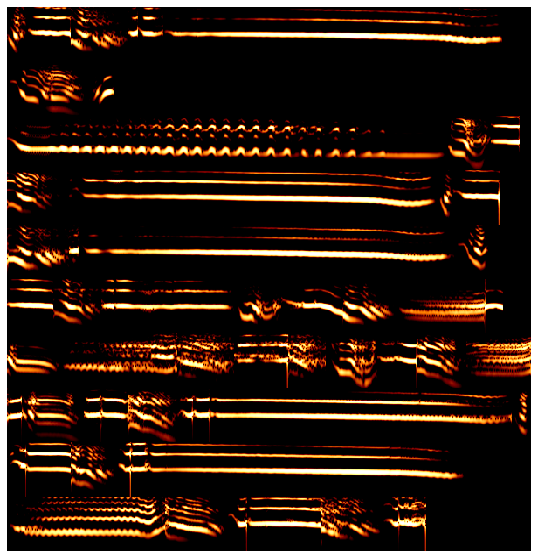

In [34]:
# lets take a look at these spectrograms
draw_spec_set(segs_spec, zoom=1, maxrows=10, colsize=25)

In [35]:
np.shape(segs_spec[0])

(64, 24)

### Rescale spectrogram
- using log scaling

In [36]:
# hyperparameter, where larger = higher dimensional spectrogram
log_scaling_factor = 10

In [37]:
import tensorflow as tf

In [38]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    segs_spec_log = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(segs_spec, desc="scaling spectrograms", leave=False)
    )

scaling spectrograms:   0%|          | 0/1644 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0071s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0230s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0214s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0250s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch com

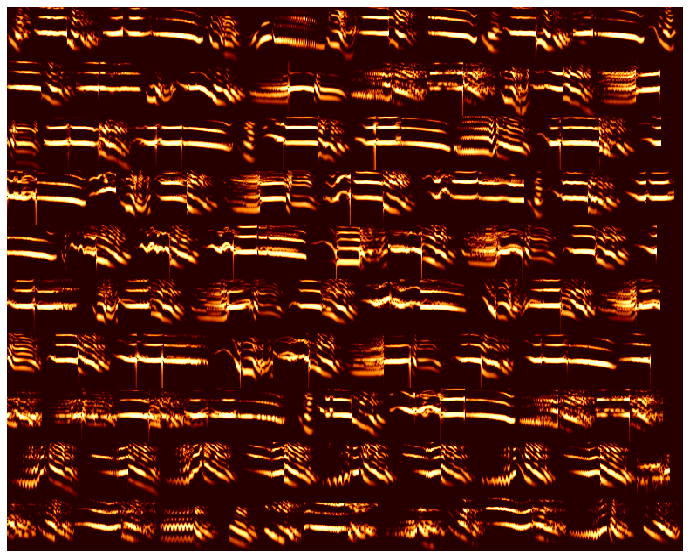

In [39]:
draw_spec_set(segs_spec_log, zoom=1, maxrows=10, colsize=25)

In [40]:
np.shape(segs_spec_log[0])

(64, 31)

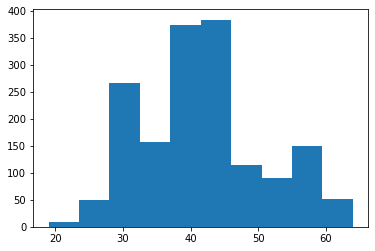

In [41]:
seg_lens = [np.shape(i)[1] for i in segs_spec_log]
plt.hist(seg_lens);

In [42]:
max(seg_lens)

64

## Zero Padding Spectrograms

In [43]:
pad_length = np.max(seg_lens)

In [44]:
import seaborn as sns

C:\Users\slwal\anaconda3\envs\PY36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\slwal\anaconda3\envs\PY36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\slwal\anaconda3\envs\PY36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

TypeError: 'module' object is not callable

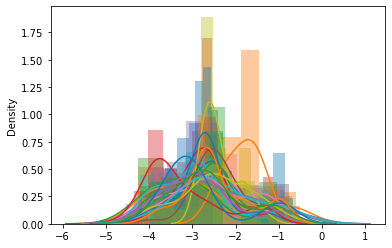

In [45]:
for indv in np.unique(seg_df.indv):
    sns.distplot(np.log(seg_df[seg_df.indv==indv]["end_time"] - seg_df[seg_df.indv==indv]["start_time"]), label=indv)
plt()

In [46]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    segs_spec_logpad = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            segs_spec_log, desc="padding spectrograms", leave=False
        )
    )

padding spectrograms:   0%|          | 0/1644 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0050s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0253s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0211s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0256s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch com

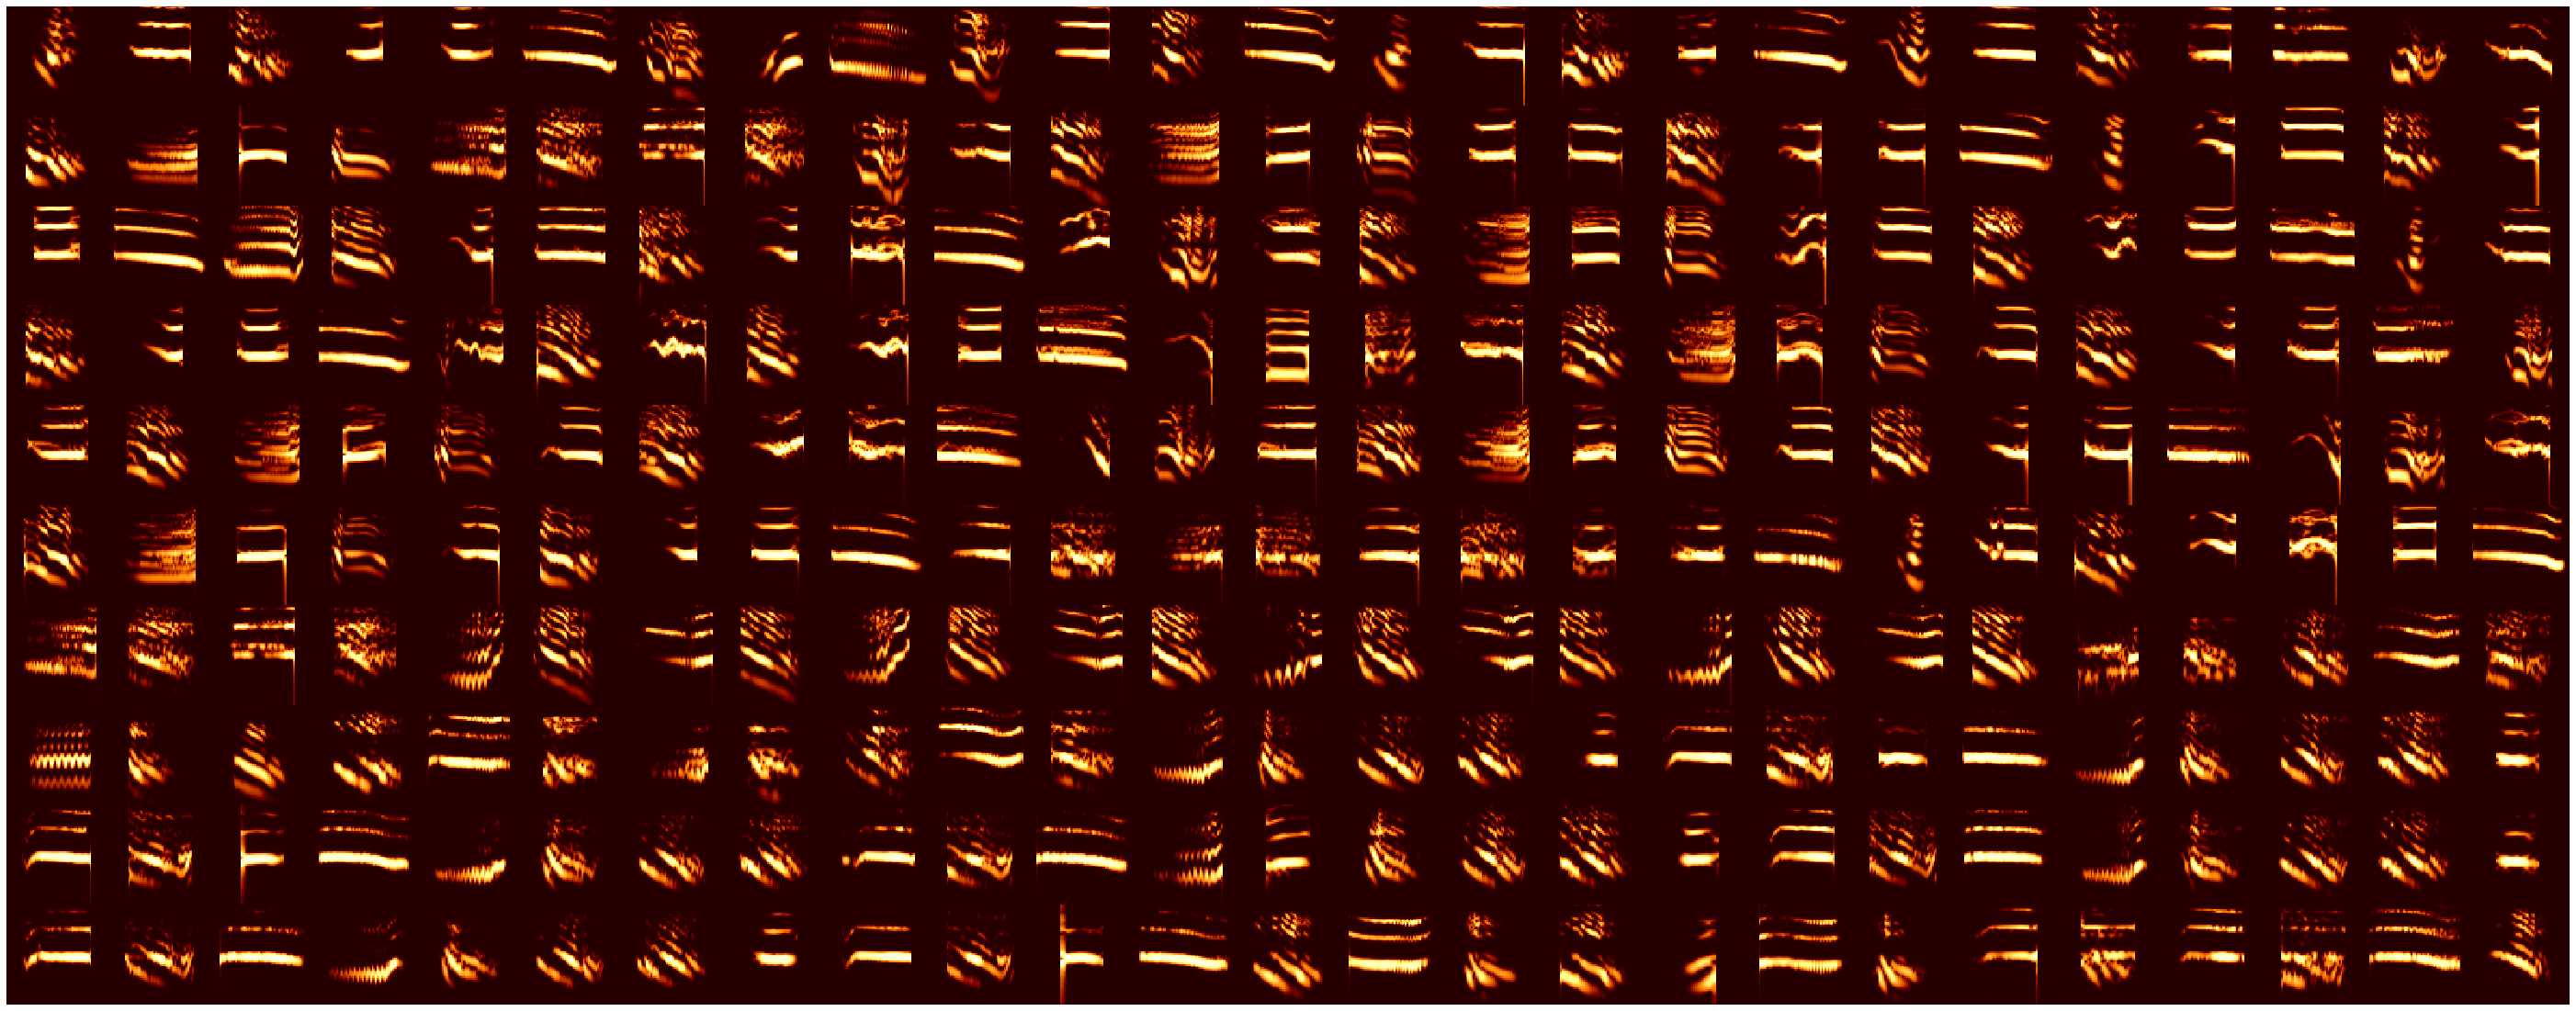

In [47]:
draw_spec_set(segs_spec_logpad, zoom=2, maxrows=10, colsize=25)

In [48]:
np.shape(segs_spec_logpad)

(1644, 64, 64)

## Put info into dataframes

In [49]:
seg_df['specs'] = segs_spec_logpad

In [50]:
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,indvi,filename,group,location,sex,wav_loc,key,audio,rate,specs
0,0.753604,0.776773,DS,0,0.753604,0.776773,DSSHDS,0.753604,0,0,...,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,"[0.00406307, 0.0047037005, 0.005138306, 0.0066...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,"[-0.002149772, 0.028191859, 0.04111525, 0.0405...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0.855941,0.921160,DS,2,0.855941,0.921160,DSSHDS,0.753604,2,0,...,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,"[0.10028901, -0.03837672, -0.19384652, -0.3224...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### save dataset

In [51]:
from avgn.utils.paths import DATA_DIR, ensure_dir

In [52]:
from datetime import datetime
import IPython
from pathlib2 import Path

In [53]:
save_loc = DATA_DIR / 'git_repos' / DT_ID /  'walsh_magpie_gitrepos.pickle'
ensure_dir(save_loc.as_posix())
# we'll save without the audio (optional)
seg_df.drop('audio', 1).to_pickle(save_loc)